# Formative Assessment

### The goal

The goal of the assignment is to predict active power of a wind turbine using several input features. The data comes from a wind farm in France, [La Haute Borne Data (2013-2016)](https://opendata-renewables.engie.com/explore/dataset/la-haute-borne-data-2013-2016/table/?dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6ImxhLWhhdXRlLWJvcm5lLWRhdGEtMjAxMy0yMDE2Iiwib3B0aW9ucyI6e319LCJjaGFydHMiOlt7InR5cGUiOiJsaW5lIiwiZnVuYyI6IkFWRyIsInlBeGlzIjoiYmFfYXZnIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiIzY2YzJhNSJ9XSwieEF4aXMiOiJkYXRlX3RpbWUiLCJtYXhwb2ludHMiOiIiLCJ0aW1lc2NhbGUiOiJ5ZWFyIiwic29ydCI6IiJ9XX0%3D). A total of 139 features are included in the dataset, with several measures of the same feature. For instance, the active power feature is split into the following measurements: `P_min, P_max, P_avg, P_std`. 

The overall tasks are the following:

1. Use a random forest regressor to predict power output. 
2. Perform dimension reduction using PCA.
2. Perform cross validation to determine how well the model generalises. 
3. Determine the importance of the features.
4. Determine the performance of the models as well.

The notebook will guide you as to how to go about fulfilling these overall tasks by doing other smaller subtasks.

Note that the dataset is very large, with 139 columns, so using a bit of domain knowledge we identified the following features that could be using in predicting wind turbine power output. Add to the feature subset as you build the model.



### Load the data

Import the necessary libraries and load the data. Once loaded, investigate the data. There are two files: `data_description.csv` lists the variables or features of the dataset. The file `wind-data.csv` contains the data (`wind-data-truncated.csv` if downloaded from the LMS, due to file size limits).

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

Load both the `data_description.csv` and `wind-data.csv` files.

In [95]:
data_descrip = pd.read_csv("data_description.csv", sep=';')

In [96]:
wind_data = pd.read_csv("wind-data-truncated.csv", parse_dates=['Date_time'])

__Helpful hint__: Load the data into a dataframe. Use the `parse_dates=['Date_time']` argument in the `read_csv` function in order to display dates in later plots.

In [97]:
data_descrip.head()

,Variable_name,Variable_long_name,Unit_long_name,Comment
0,Va2,Vane_position_2,deg,Second wind vane on the nacelle
1,Ws2,Wind_speed_2,m/s,Second anemometer on the nacelle
2,Ws,Wind_speed,m/s,Average wind speed
3,Wa_c,Absolute_wind_direction_corrected,deg,NaN
4,Na_c,Nacelle_angle_corrected,deg,NaN


In [98]:
wind_data.head(5)

,Unnamed: 0,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,804808,R80711,2013-04-06 14:20:00,-0.940000,-0.950000,-0.940000,0.0,10.59,10.000000,11.0,...,NaN,NaN,358.870000,NaN,NaN,NaN,351.670010,NaN,NaN,NaN
1,732424,R80711,2015-12-22 14:30:00,-0.990000,-0.990000,-0.990000,0.0,17.00,17.000000,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,312987,R80711,2016-03-20 20:40:00,-0.990000,-0.990000,-0.990000,0.0,12.88,12.000000,13.0,...,NaN,NaN,44.849998,NaN,NaN,NaN,44.849998,NaN,NaN,NaN
3,68152,R80711,2016-01-09 01:00:00,45.000000,45.000000,45.000000,0.0,12.95,12.000000,13.0,...,NaN,NaN,243.020000,NaN,NaN,NaN,243.020000,NaN,NaN,NaN
4,231878,R80721,2014-12-14 13:20:00,44.990002,44.990002,44.990002,0.0,16.99,16.110001,17.0,...,NaN,NaN,195.060000,NaN,NaN,NaN,308.239990,NaN,NaN,NaN


### Explore the data

Once you've loaded the data into a pandas dataframe, explore the data. You may start by generating summary statistics, identifying any missing values, and filling in missing values. Generate visualizations of the features as a way to start understanding the distribution of the data.

In [99]:
wind_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 139 entries, Unnamed: 0 to Na_c_std
dtypes: datetime64[ns](1), float64(136), int64(1), object(1)
memory usage: 26.5+ MB


In [100]:
wind_data.describe()

,Unnamed: 0,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
count,25000.000000,24863.000000,24863.000000,24863.000000,24863.000000,24863.000000,24863.000000,24863.000000,24863.000000,24863.000000,...,0.0,0.0,24023.000000,0.0,0.0,0.0,24023.000000,0.0,0.0,0.0
mean,420690.593400,13.908417,12.809536,15.365060,0.860982,19.315983,19.122009,19.535519,0.105912,1055.278639,...,NaN,NaN,178.370313,NaN,NaN,NaN,179.284643,NaN,NaN,NaN
std,242467.126033,28.292036,28.123074,28.840993,3.873753,6.183012,6.194615,6.186675,0.157304,626.559284,...,NaN,NaN,95.777425,NaN,NaN,NaN,95.969775,NaN,NaN,NaN
min,29.000000,-1.050000,-23.040001,-1.050000,0.000000,5.000000,4.940000,5.000000,0.000000,-574.880000,...,NaN,NaN,0.000000,NaN,NaN,NaN,0.080000,NaN,NaN,NaN
25%,211555.500000,-0.990000,-1.000000,-0.990000,0.000000,14.080000,14.000000,15.000000,0.000000,963.825015,...,NaN,NaN,86.075001,NaN,NaN,NaN,86.779999,NaN,NaN,NaN
50%,421692.500000,-0.970000,-0.990000,-0.500000,0.000000,19.000000,19.000000,19.000000,0.000000,1180.170000,...,NaN,NaN,195.190000,NaN,NaN,NaN,196.710010,NaN,NaN,NaN
75%,629736.500000,7.125000,-0.500000,44.980000,0.130000,24.000000,24.000000,24.000000,0.210000,1565.585000,...,NaN,NaN,248.300000,NaN,NaN,NaN,250.050000,NaN,NaN,NaN
max,840316.000000,117.130000,117.130000,161.770000,45.220001,39.000000,39.000000,39.000000,0.940000,1805.770000,...,NaN,NaN,359.950010,NaN,NaN,NaN,359.950010,NaN,NaN,NaN


In [101]:
wind_data.isnull().sum(axis=0) 

Unnamed: 0               0
Wind_turbine_name        0
Date_time                0
Ba_avg                 137
Ba_min                 137
Ba_max                 137
Ba_std                 137
Rt_avg                 137
Rt_min                 137
Rt_max                 137
Rt_std                 137
DCs_avg                137
DCs_min                137
DCs_max                137
DCs_std                137
Cm_avg                 137
Cm_min                 137
Cm_max                 137
Cm_std                 137
P_avg                  137
P_min                  137
P_max                  137
P_std                  137
Q_avg                  137
Q_min                  137
Q_max                  137
Q_std                  137
S_avg                  137
S_min                  137
S_max                  137
                     ...  
Nf_max                 137
Nf_std                 137
Nu_avg                 137
Nu_min                 137
Nu_max                 137
Nu_std                 137
R

In [102]:
#imputting missing values with the zero value 
wind_data_clean = wind_data.fillna(0)
wind_data_clean.tail()


,Unnamed: 0,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
24995,343924,R80711,2014-11-13 19:50:00,-0.99,-0.99,-0.99,0.00,16.00,16.0,16.00,...,0.0,0.0,112.330000,0.0,0.0,0.0,94.220001,0.0,0.0,0.0
24996,256691,R80790,2013-12-20 00:30:00,-0.95,-0.95,-0.94,0.00,15.51,15.0,16.00,...,0.0,0.0,224.250000,0.0,0.0,0.0,223.980000,0.0,0.0,0.0
24997,545539,R80711,2016-06-20 20:30:00,-0.99,-0.99,-0.99,0.00,22.00,22.0,22.24,...,0.0,0.0,234.160000,0.0,0.0,0.0,234.160000,0.0,0.0,0.0
24998,452358,R80736,2014-10-21 13:50:00,2.62,-0.99,13.42,3.82,22.00,22.0,22.00,...,0.0,0.0,275.239990,0.0,0.0,0.0,277.929990,0.0,0.0,0.0
24999,563047,R80790,2016-10-14 06:20:00,-0.82,-1.00,0.00,0.32,15.02,15.0,15.78,...,0.0,0.0,73.760002,0.0,0.0,0.0,73.760002,0.0,0.0,0.0


In [103]:
wind_data_clean.isnull().sum(axis=0) 

Unnamed: 0           0
Wind_turbine_name    0
Date_time            0
Ba_avg               0
Ba_min               0
Ba_max               0
Ba_std               0
Rt_avg               0
Rt_min               0
Rt_max               0
Rt_std               0
DCs_avg              0
DCs_min              0
DCs_max              0
DCs_std              0
Cm_avg               0
Cm_min               0
Cm_max               0
Cm_std               0
P_avg                0
P_min                0
P_max                0
P_std                0
Q_avg                0
Q_min                0
Q_max                0
Q_std                0
S_avg                0
S_min                0
S_max                0
                    ..
Nf_max               0
Nf_std               0
Nu_avg               0
Nu_min               0
Nu_max               0
Nu_std               0
Rs_avg               0
Rs_min               0
Rs_max               0
Rs_std               0
Rbt_avg              0
Rbt_min              0
Rbt_max    

In [104]:
print (wind_data_clean.shape)

(25000, 139)


Because we are investigating power output, the active power feature is given by the following features in  the dataset: `P_avg, P_min, P_max, P_std`. Decide on which active power feature to use (hint: perhaps the average or maximum would be a good place to start). Begin by using the function `groupby` to determine how many turbines there are in the dataset. The dataset is huge, so in order to visualize trends in power output, a simpler way would be to look at monthly trends in the data.

In [105]:
wind_data_clean.groupby(['Wind_turbine_name']).mean()


,Unnamed: 0,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
Wind_turbine_name,,,,,,,,,,,,,,,,,,,,,
R80711,288751.011725,9.564900,8.458262,11.076237,0.875389,18.107070,17.940922,18.276091,0.084505,1157.775492,...,0.0,0.0,171.408667,0.0,0.0,0.0,171.788413,0.0,0.0,0.0
R80721,403385.883331,10.589124,9.372305,12.132818,0.955923,20.421272,20.214032,20.610209,0.099174,1067.149327,...,0.0,0.0,169.342361,0.0,0.0,0.0,170.037433,0.0,0.0,0.0
R80736,508117.399456,10.664115,9.498149,12.120208,0.882334,19.273847,19.005123,19.650690,0.167949,1080.325400,...,0.0,0.0,172.718300,0.0,0.0,0.0,173.936279,0.0,0.0,0.0
R80790,481871.198692,24.460166,23.577484,25.744376,0.711874,19.033377,18.903703,19.172124,0.069783,893.671952,...,0.0,0.0,172.129807,0.0,0.0,0.0,173.348766,0.0,0.0,0.0


There is a wind turbine with `Wind_turbine_name` R80711. Use this column and determine the trend for the month of January.

In [106]:
wind_data_date = wind_data_clean.groupby(['Wind_turbine_name',"Date_time"]).mean()
wind_data_date["P_avg"]

Wind_turbine_name  Date_time          
R80711             2013-01-01 00:40:00    1062.010000
                   2013-01-01 01:00:00    1199.260000
                   2013-01-01 02:40:00    1217.550000
                   2013-01-01 07:10:00    1471.630000
                   2013-01-01 10:20:00     994.679990
                   2013-01-01 15:10:00     378.149990
                   2013-01-02 07:30:00      92.199997
                   2013-01-02 13:30:00      -1.190000
                   2013-01-03 06:50:00     865.109990
                   2013-01-03 08:00:00     485.149990
                   2013-01-03 11:50:00     426.570010
                   2013-01-03 14:40:00     220.590000
                   2013-01-03 21:40:00     348.350010
                   2013-01-04 08:40:00     598.590030
                   2013-01-04 22:50:00     125.580000
                   2013-01-04 23:50:00     153.030000
                   2013-01-05 00:00:00     226.050000
                   2013-01-05 01:40:00     

In [127]:
import datetime as dt
range_min = wind_data_clean['Date_time'].min()
range_max = range_min + dt.timedelta(days=30)
print(range_min, range_max)

2013-01-01 00:40:00 2013-01-31 00:40:00


In [128]:
# Extracting the readings for January 

jan_reading = wind_data.loc[(range_min < wind_data['Date_time']) & (range_max > wind_data['Date_time'])].sort_values((['Wind_turbine_name', 'Date_time']))

In [129]:
jan_reading.head()

,Unnamed: 0,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
4274,333007,R80711,2013-01-01 01:00:00,-1.00,-1.0,-1.00,0.00,12.17,12.0,13.00,...,NaN,NaN,188.81,NaN,NaN,NaN,192.89999,NaN,NaN,NaN
5465,304915,R80711,2013-01-01 02:40:00,-0.97,-1.0,0.14,0.12,12.01,12.0,12.62,...,NaN,NaN,191.23,NaN,NaN,NaN,192.89999,NaN,NaN,NaN
5335,183314,R80711,2013-01-01 07:10:00,-0.56,-1.0,4.27,0.77,13.21,13.0,14.00,...,NaN,NaN,194.47,NaN,NaN,NaN,192.89999,NaN,NaN,NaN
22638,304900,R80711,2013-01-01 10:20:00,-1.00,-1.0,-1.00,0.00,12.90,12.0,13.00,...,NaN,NaN,216.41,NaN,NaN,NaN,211.50999,NaN,NaN,NaN
8823,811433,R80711,2013-01-01 15:10:00,-1.00,-1.0,-1.00,0.00,12.01,12.0,12.96,...,NaN,NaN,254.94,NaN,NaN,NaN,264.66998,NaN,NaN,NaN


In [132]:
# Extracting values for Turbine 80711
turbine_R80711 = jan_reading.loc[(jan_reading.Wind_turbine_name == 'R80711'),["Date_time", 'P_avg']]


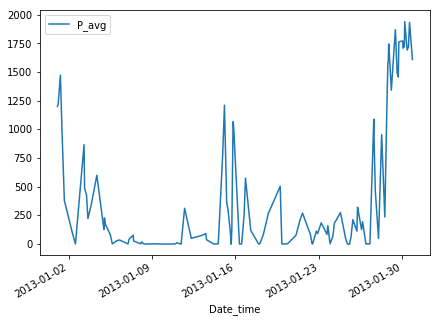

In [133]:
turbine_R80711.plot(x='Date_time', y='P_avg', figsize=(7,5))

### Find missing values

A dataset with missing values will not be usable for fitting and testing a model. Fill in missing values in a way suitable for the model.

In [ ]:
#done in line 42

### Split dataset into predictor and target matrices

In [134]:
# Generate new class attribute. Is P_min + P_max above P_avg? 1= yes / 0 = no
wind_data_clean['aboveAVG'] = np.where((wind_data_clean['P_min'] + wind_data_clean['P_max'])>=(wind_data_clean['P_avg']), 1, 0)

In [136]:
# Values of target
y = wind_data_clean['aboveAVG'].values

# Values of attributes
wind_data_x = wind_data_clean.drop(['Unnamed: 0','Wind_turbine_name', 'Date_time','P_min', 'P_max', 'P_avg', 'P_std','aboveAVG'], axis=1)
X = wind_data_x.values

In [137]:
number_features = len(wind_data_x.columns)
number_features

132

### Dimension Reduction with PCA

The dataset we have it quite huge. We need to select features to use for our analysis of the active power. To discover the principal features, we can principal component analysis. First split the data into predictor and target variables. PCA allows you to reduce the number of you predictors, and to decorrelate them especially for features that have a direct relationship like apparent power, reactive power and active power.

In [138]:
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

In [139]:
# Initializing and fitting
pca=PCA(n_components=number_features)
pca.fit(X)  

PCA(copy=True, iterated_power='auto', n_components=132, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [140]:
PCA(copy=True, n_components=None, whiten=False)
pca.components_
# Evaluating the components

array([[-0.00242657, -0.00236395, -0.0023579 , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.00667962,  0.00599586,  0.0076749 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0218457 ,  0.02160377,  0.02214413, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

### Plot the variance

In [141]:
pca.explained_variance_ratio_ # To get how the principal components describe the variance in the data

array([9.28867433e-01, 3.39639271e-02, 2.05527304e-02, 8.09065593e-03,
       3.95833461e-03, 1.39855076e-03, 1.21459000e-03, 3.67771058e-04,
       2.59064697e-04, 2.32635310e-04, 1.97233094e-04, 1.69857742e-04,
       1.61787201e-04, 1.16878125e-04, 9.35565889e-05, 5.46894518e-05,
       4.70364003e-05, 4.35911391e-05, 3.91084043e-05, 2.70649065e-05,
       2.67872413e-05, 2.46572802e-05, 1.45707282e-05, 1.11150578e-05,
       1.07690445e-05, 1.02781999e-05, 9.88847864e-06, 8.45701070e-06,
       4.93127290e-06, 3.91004000e-06, 3.34373997e-06, 2.91745881e-06,
       1.93417733e-06, 1.84961495e-06, 1.79094975e-06, 1.01092607e-06,
       7.46778688e-07, 6.96575458e-07, 5.24987819e-07, 4.04036793e-07,
       3.99999329e-07, 3.25630639e-07, 2.90674667e-07, 2.58094018e-07,
       2.53367310e-07, 2.26403177e-07, 2.15610855e-07, 1.83466246e-07,
       1.50045960e-07, 1.07585573e-07, 7.00999829e-08, 6.03312407e-08,
       5.53634415e-08, 4.89002233e-08, 4.54995853e-08, 4.41466246e-08,
      

In [142]:
pca.explained_variance_

array([3.56042933e+07, 1.30186675e+06, 7.87803959e+05, 3.10121850e+05,
       1.51726394e+05, 5.36076619e+04, 4.65562868e+04, 1.40969832e+04,
       9.93017425e+03, 8.91711295e+03, 7.56011536e+03, 6.51079438e+03,
       6.20144354e+03, 4.48003976e+03, 3.58610509e+03, 2.09629406e+03,
       1.80294597e+03, 1.67088612e+03, 1.49905901e+03, 1.03742131e+03,
       1.02677816e+03, 9.45134908e+02, 5.58508635e+02, 4.26049793e+02,
       4.12786803e+02, 3.93972305e+02, 3.79033952e+02, 3.24164546e+02,
       1.89019962e+02, 1.49875220e+02, 1.28168449e+02, 1.11828723e+02,
       7.41386925e+01, 7.08973432e+01, 6.86486554e+01, 3.87496720e+01,
       2.86246740e+01, 2.67003407e+01, 2.01232379e+01, 1.54870803e+01,
       1.53323208e+01, 1.24817045e+01, 1.11418118e+01, 9.89296729e+00,
       9.71178845e+00, 8.67822990e+00, 8.26455082e+00, 7.03242012e+00,
       5.75139162e+00, 4.12384819e+00, 2.68699307e+00, 2.31254872e+00,
       2.12212867e+00, 1.87438792e+00, 1.74403852e+00, 1.69217836e+00,
      

In [143]:
variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
variance

array([92.9, 96.3, 98.4, 99.2, 99.6, 99.7, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8,
       99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8])

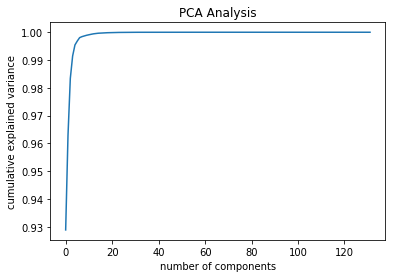

In [144]:
# Using a scree plot to show the variance explained by each principal component within the dataset
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA Analysis')
plt.show()

### Random Forest with PCA

Construct a PCA and Random Forest Regressor pipeline. A pipeline is a term for the processing of data until it reaches a form that is usable for the machine learning algorithm. Now there is an actual pipeline module you'll need to use, that streamlines the process of dimension reduction and application of the machine learning algorithm, in this case the random forest regression model. For now, use the first two principal components to construct the pipeline.

In [145]:
pca = PCA(n_components=2) # Choosing 2 principal components
X_r = pca.fit(X).transform(X)
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1) # Using random forest regression model
pipeline = Pipeline(steps=[('pca', pca), ('forest', forest)]) # Pipeline with Random Forest and PCA

### Plot the principal components

Select the first two components and display them. As rule of thumb, the first to components are selected as they are easier to display in a 2-dimensions.

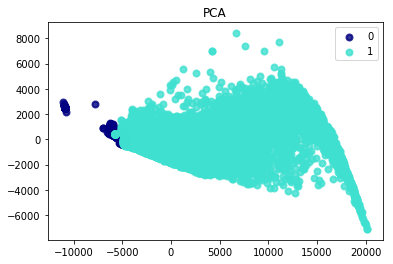

In [147]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], [0, 1]):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')

plt.show()

### Split dataset in training and test sets

Split the data into training and test sets and use the pipeline to fit and test the model.

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [149]:
# Fitting with the pipeline
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
         ...mators=10000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [151]:
y_pred = pipeline.predict(X_test)

In [152]:
# Score
pipeline.score(X_test, y_test)

0.998

### Evaluate the results

Using the `sklearn.metrics` moduel determine the accuracy score, i.e., the coefficient of determination $R^2$ of the prediction.

In [153]:
from sklearn.metrics import r2_score

In [154]:
print(r2_score(y_test, y_pred))

0.988898949455782


### References

Referred to for determination of input features to predict power output: [Forecasting Wind Power](https://lucdemortier.github.io/articles/17/WindPower).

[Selecting good features – Part IV: stability selection, RFE and everything side by side](http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/)